# Pipeline: Regression Models

## 1. Introduction

Ten years' worth of AstraZeneca Adjusted Close price data will be used to see if it possible to forecast out 'n' days in the future. Fourteen models will be compared to see whether Gradient-Descent Based, Distance-Based or Tree-Based algorithms perform best.

After a spot check of the models the best performing will be selected and Grid Search cross validation will then be used to find the best parameters for tuning the models, and visualising the results.




## 2. Install/import libraries

In [1]:
# !pip install yfinance as yfinance

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from scipy import stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
%matplotlib inline

# Import the models
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor, BaggingRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')


## 3. Import data
Ten years of AstraZeneca stock data will be downloaded from Yahoo! Finance using the yfinance API.

In [3]:
# gold = yf.download("GC=F", start="2010-01-01", end="2023-01-05")[['Adj Close','Open', 'High', 'Low', 'Close', 'Volume']].round(2)

crude = yf.download("CL=F", start="2010-01-01", end="2023-01-15")
crude.tail()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-01-09,73.470001,76.739998,73.470001,74.629997,74.629997,329290
2023-01-10,74.860001,75.919998,73.839996,75.120003,75.120003,307430
2023-01-11,74.779999,77.839996,74.309998,77.410004,77.410004,350891
2023-01-12,77.699997,79.160004,77.099998,78.389999,78.389999,307705
2023-01-13,78.320000,80.110001,77.970001,79.860001,79.860001,307705


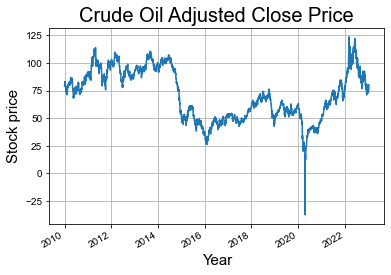

In [4]:
# Plot Adjusted Close price

crude['Adj Close'].plot(grid = True)
sns.set(rc={'figure.figsize':(15, 9)})
plt.title('Crude Oil Adjusted Close Price', color = 'black', fontsize = 20)
plt.xlabel('Year', color = 'black', fontsize = 15)
plt.ylabel('Stock price', color = 'black', fontsize = 15);

In [5]:
# Create Dataframe for Adjusted Close prices

crude_adj = crude[['Adj Close']]
crude_adj 

,Adj Close
Date,
2009-12-31,79.360001
2010-01-04,81.510002
2010-01-05,81.769997
2010-01-06,83.180000
2010-01-07,82.660004
...,...
2023-01-09,74.629997
2023-01-10,75.120003
2023-01-11,77.410004


## 4. Feature engineering
The Adjusted Close price will be shifted 'n' days in the future to create a column of prices for prediction.

In [6]:
# A variable for predicting 'n' days into the future

forecast_out = 30

# Create column for target variable shifted 'n' days up
crude_adj['Prediction'] = crude_adj[['Adj Close']].shift(-forecast_out)

crude_adj

,Adj Close,Prediction
Date,,
2009-12-31,79.360001,77.010002
2010-01-04,81.510002,77.330002
2010-01-05,81.769997,79.059998
2010-01-06,83.180000,79.809998
2010-01-07,82.660004,80.160004
...,...,...
2023-01-09,74.629997,NaN
2023-01-10,75.120003,NaN
2023-01-11,77.410004,NaN


## 5. Splitting the data

The last 'n' rows will be removed as these rows are NaNs in the Prediction column (y variable). 

In [7]:
X = np.array(crude_adj.drop(['Prediction'], 1))
# Remove last 'n' rows
X = X[:-forecast_out]

print(X)

[[79.36000061]
 [81.51000214]
 [81.76999664]
 ...
 [77.23999786]
 [78.19999695]
 [80.55000305]]


In [8]:
y = np.array(crude_adj['Prediction'])
# Remove last 'n' rows
y = y[:-forecast_out]

print(y)

[77.01000214 77.33000183 79.05999756 ... 77.41000366 78.38999939
 79.86000061]


The data will be split into training and test sets.

In [9]:
train_size = int(X.shape[0]*0.7)

X_train = X[0:train_size]
y_train = y[0:train_size]

X_test = X[train_size:]
y_test = y[train_size:]

In [10]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2276, 1)
(2276,)
(976, 1)
(976,)


In [11]:
print(X_train)
print(y_train)

[[79.36000061]
 [81.51000214]
 [81.76999664]
 ...
 [52.31000137]
 [52.06999969]
 [53.79999924]]
[77.01000214 77.33000183 79.05999756 ... 55.79999924 56.59000015
 56.56000137]


The last 'n' days of the Adjusted Close price will be saved as an array.

In [12]:
X_forecast = np.array(crude_adj.drop(['Prediction'],1))[-forecast_out:]
print(X_forecast)

[[81.22000122]
 [79.98000336]
 [76.93000031]
 [74.25      ]
 [72.01000214]
 [71.45999908]
 [71.01999664]
 [73.16999817]
 [75.38999939]
 [77.27999878]
 [76.11000061]
 [74.29000092]
 [75.19000244]
 [76.08999634]
 [78.29000092]
 [77.48999786]
 [79.55999756]
 [79.52999878]
 [78.95999908]
 [78.40000153]
 [80.26000214]
 [76.93000031]
 [72.83999634]
 [73.66999817]
 [73.76999664]
 [74.62999725]
 [75.12000275]
 [77.41000366]
 [78.38999939]
 [79.86000061]]


## 6. Evaluate algorithms

A dictionary of models will be created to spot check using default parameters, and select the best performing ones for tuning.

In [13]:
models = {}
models["Linear"] = LinearRegression()
models["Lasso"] = Lasso()
models["Ridge"] = Ridge()
models["ElasticNet"] = ElasticNet()
models["KNN"] = KNeighborsRegressor()
models["DecisionTree"] = DecisionTreeRegressor()
models["SVR"] = SVR(kernel='rbf', C=1e3, gamma='scale')
models["AdaBoost"] = AdaBoostRegressor()
models["GradientBoost"] = GradientBoostingRegressor()
models["RandomForest"] = RandomForestRegressor()
models["ExtraTrees"]= ExtraTreesRegressor()
models["BaggingRegressor"] = BaggingRegressor()
models["XGBRegressor"] = XGBRegressor(objective ='reg:squarederror')
models["MLPRegressor"] = MLPRegressor(solver = 'lbfgs')

###  Spot check algorithms



To avoid look-ahead bias we will use sklearn's TimeSeriesSplit class so that models are not trained on data they have already seen. 



In [14]:
model_results = []  
model_names   = []
for model_name in models:
    model = models[model_name]
    # TimeSeries Cross validation
    tscv = TimeSeriesSplit(n_splits=7)
    
    cv_results = cross_val_score(model, X_train, y_train, cv=tscv, scoring='r2')
    model_results.append(cv_results)
    model_names.append(model_name)
    print("{}: {}, ({})".format(model_name, round(cv_results.mean(), 6), round(cv_results.std(), 6)))

Linear: -0.221065, (0.457504)
Lasso: -0.2264, (0.460148)
Ridge: -0.221058, (0.457509)
ElasticNet: -0.225276, (0.459522)
KNN: -1.135299, (0.754489)
DecisionTree: -2.161879, (0.992277)
SVR: -1.946775, (1.554914)
AdaBoost: -1.145224, (0.685866)
GradientBoost: -1.0549, (0.485892)
RandomForest: -1.494349, (0.761482)
ExtraTrees: -1.797658, (0.800125)
BaggingRegressor: -1.569132, (0.726739)
XGBRegressor: -1.538914, (0.765081)
MLPRegressor: -0.230538, (0.471657)


### Boxplot to compare regression models

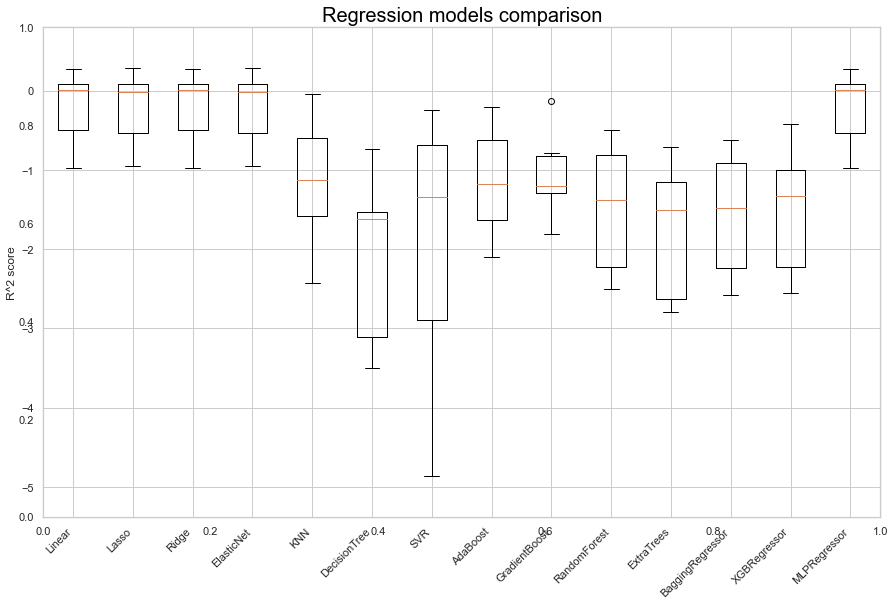

In [16]:
# Compare algorithms  

def box_compare():
  sns.set(rc={'figure.figsize':(15, 9)})
  sns.set_style(style='whitegrid', )
  figure = plt.figure()
  plt.title('Regression models comparison', color = 'black', fontsize = 20)
  axis = figure.add_subplot(111)
  plt.boxplot(model_results)
  axis.set_xticklabels(model_names, rotation = 45, ha="right")
  axis.set_ylabel("R^2 score")
  plt.margins(0.05, 0.1)

box_compare()

The performance scores and box plots show that the linear models and the neural network perform the best. We will select Linear Regression and the MLP Regressor. Both are Gradient-Descent based models, although one is linear and the other non-linear.

## 7. Modelling

We will create, train, test and tune Linear Regression and MLP Regressor models.

### 7.1 Create, train and predict on Linear Regression model

We will look at the Linear Regression model first. It adopts a linear approach to modelling the relationship between a dependent variable and independent variable(s), and is also the simplest form of machine learning.









In [17]:
# Create Linear Regression model
lr = LinearRegression()

# Train the model
lr.fit(X_train, y_train)

LinearRegression()

In [18]:
# Make predictions using the model
predictions = lr.predict(X_test)

### Print performance metrics
The performance metric R<sup>2</sup>, or the coefficient of determination, tells us how much variance in the target variable is explained by our model. Values can range from 0 to 1. In general higher values are better, indicating that a model is highly predictive.

In [19]:
# The coefficients
print('Coefficients: ', lr.coef_)
# The mean squared error
print('RMSE: {}'.format(round(mean_squared_error(y_test, predictions, squared=False), 3)))
# Explained variance score: 1 is perfect prediction, 0 is random
print('R^2 score: {}'.format(round(r2_score(y_test, predictions), 3)))

Coefficients:  [0.94963486]
RMSE: 10.496
R^2 score: 0.78


The R<sup>2</sup> score tells us that 78.3% of the variation in y can be explained by the dependence on X. 

### Visualise predicted vs actual prices

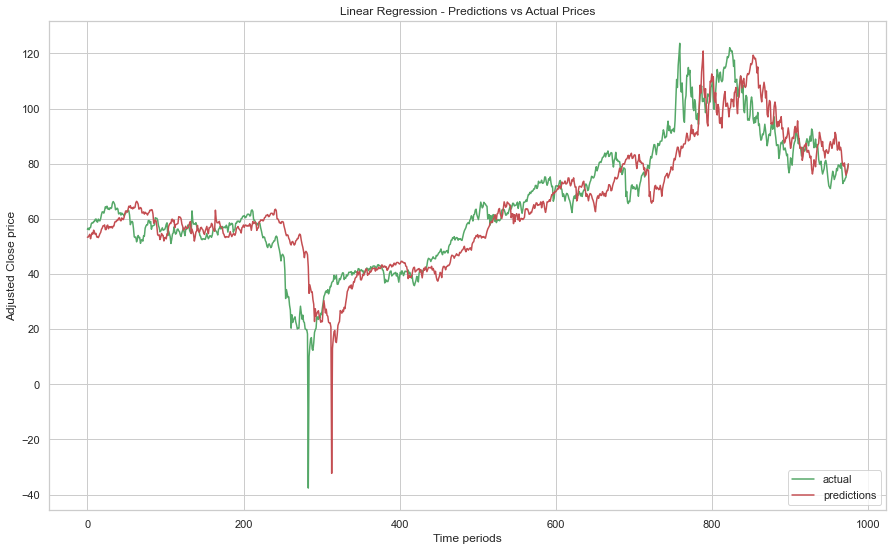

In [20]:
# Plot predictions against actual Adjusted Close prices 

x_axis = np.array(range(0, predictions.shape[0]))
plt.plot(x_axis, y_test, color='g', label="actual")
plt.plot(x_axis, predictions, color='r', label="predictions")
plt.xlabel('Time periods')
plt.ylabel('Adjusted Close price')
plt.title('Linear Regression - Predictions vs Actual Prices')
plt.legend(loc='lower right')
plt.show()

### Create DataFrame of actual vs predicted prices

In [21]:
pd.DataFrame({"Actual": y_test, "Predict": predictions}).head()

,Actual,Predict
0,56.220001,53.358869
1,56.660000,53.406350
2,56.070000,53.890666
3,56.790001,54.422459
4,56.869999,52.808083


In [22]:
pd.DataFrame({"Actual": y_test, "Predict": predictions}).tail()

,Actual,Predict
971,74.629997,77.451108
972,75.120003,75.874711
973,77.410004,76.786359
974,78.389999,77.698008
975,79.860001,79.929656


### Scatterplot

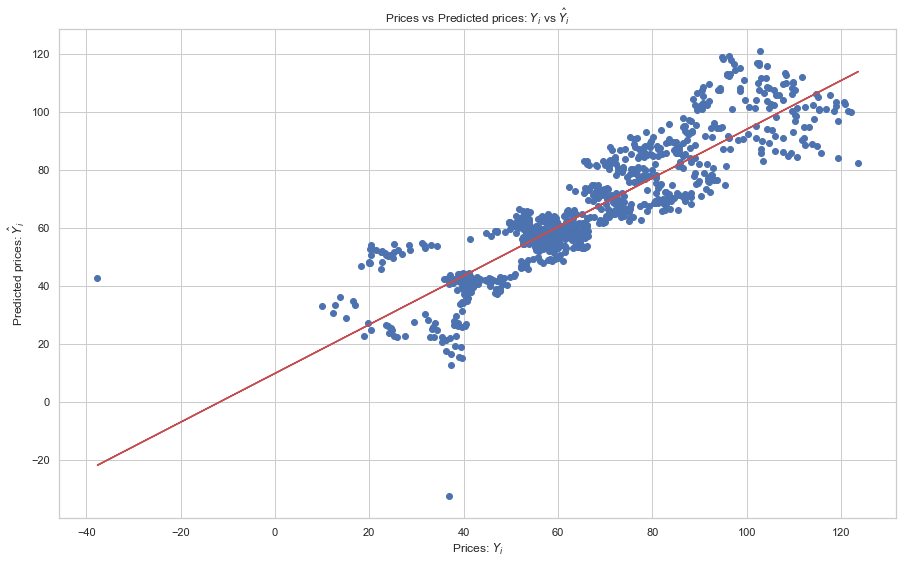

In [23]:
# create basic scatterplot
plt.scatter(y_test,predictions)

# obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(y_test, predictions, 1)

# add linear regression line to scatterplot 
plt.plot(y_test, m*y_test+b, c='r')

plt.xlabel("Prices: $Y_i$")
plt.ylabel("Predicted prices: $\hat{Y}_i$")
plt.title("Prices vs Predicted prices: $Y_i$ vs $\hat{Y}_i$")
plt.show()

### Predict next 30 days 

We will test the model on the X_forecast data and compare predictions with actual prices.

In [24]:
# Predicted prices

lr_prediction = lr.predict(X_forecast)
print(lr_prediction)

[80.56590936 79.38836416 76.49197495 73.94695323 71.81977318 71.29747111
 70.87962945 72.92134585 75.02953639 76.8243457  75.71327465 73.9849395
 74.83961232 75.6942779  77.78347893 77.02376815 78.98951202 78.96102413
 78.41973255 77.88793935 79.65426077 76.49197495 72.6079646  73.39616328
 73.49112531 74.30781187 74.77313817 76.94780287 77.87844097 79.27440537]


In [25]:
# Actual prices

X_forecast

array([[81.22000122],
       [79.98000336],
       [76.93000031],
       [74.25      ],
       [72.01000214],
       [71.45999908],
       [71.01999664],
       [73.16999817],
       [75.38999939],
       [77.27999878],
       [76.11000061],
       [74.29000092],
       [75.19000244],
       [76.08999634],
       [78.29000092],
       [77.48999786],
       [79.55999756],
       [79.52999878],
       [78.95999908],
       [78.40000153],
       [80.26000214],
       [76.93000031],
       [72.83999634],
       [73.66999817],
       [73.76999664],
       [74.62999725],
       [75.12000275],
       [77.41000366],
       [78.38999939],
       [79.86000061]])

### Print performance metrics

In [26]:
# The coefficients
print('Coefficients: ', lr.coef_)
# The mean squared error
print('RMSE: {}'.format(round(mean_squared_error(X_forecast, lr_prediction, squared=False), 3)))
# Explained variance score: 1 is perfect prediction, 0 is random
print('R^2 score: {}'.format(round(r2_score(X_forecast, lr_prediction), 3)))

Coefficients:  [0.94963486]
RMSE: 0.43
R^2 score: 0.976


The R<sup>2</sup> score tells us that 62% of the variation in y can be explained by the dependence on X. 

### Visualise predicted vs actual prices





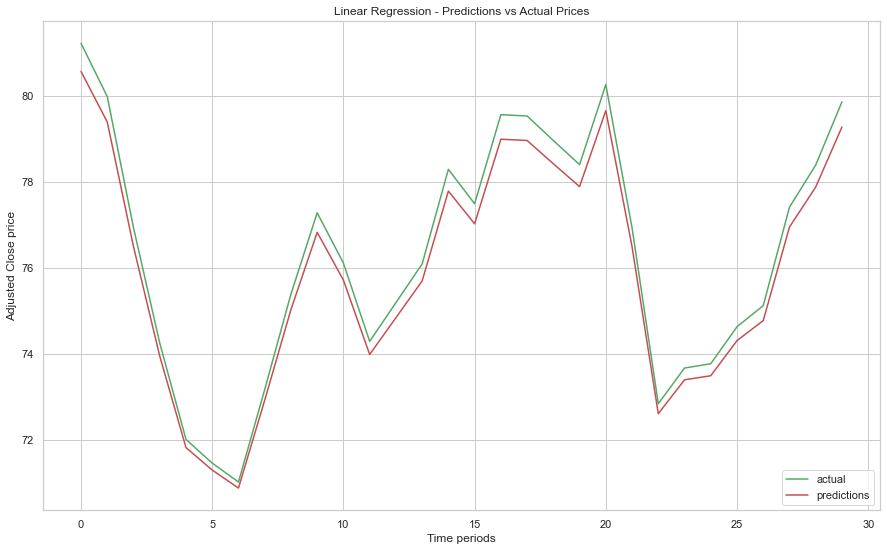

In [27]:
# Plot predictions against actual Adjusted Close prices 

x_axis = np.array(range(0, lr_prediction.shape[0]))
plt.plot(x_axis, X_forecast, color='g', label="actual")
plt.plot(x_axis, lr_prediction, color='r', label="predictions")
plt.xlabel('Time periods')
plt.ylabel('Adjusted Close price')
plt.title('Linear Regression - Predictions vs Actual Prices')
plt.legend(loc='lower right')
plt.show()

### Create DataFrame of actual vs predicted prices

In [28]:
# Reshape data to be 1D
X_forecast = X_forecast.reshape(-1)
X_forecast 

array([81.22000122, 79.98000336, 76.93000031, 74.25      , 72.01000214,
       71.45999908, 71.01999664, 73.16999817, 75.38999939, 77.27999878,
       76.11000061, 74.29000092, 75.19000244, 76.08999634, 78.29000092,
       77.48999786, 79.55999756, 79.52999878, 78.95999908, 78.40000153,
       80.26000214, 76.93000031, 72.83999634, 73.66999817, 73.76999664,
       74.62999725, 75.12000275, 77.41000366, 78.38999939, 79.86000061])

In [29]:
pd.DataFrame({"Actual": X_forecast, "Predict": lr_prediction}).head()

,Actual,Predict
0,81.220001,80.565909
1,79.980003,79.388364
2,76.930000,76.491975
3,74.250000,73.946953
4,72.010002,71.819773


### Grid Search to find optimum parameters

In [30]:
# Create dictionary of parameters
parameters = {'normalize': [True, False], 'fit_intercept': [True, False],
         'n_jobs': [None, -1]}

In [31]:
# Grid search to find best parameters
gridsearchcv_lr = GridSearchCV(estimator=lr, param_grid=parameters, cv=tscv, scoring='r2')
grid_result_lr = gridsearchcv_lr.fit(X_train, y_train)
print("Best: {} using {}".format(grid_result_lr.best_score_, grid_result_lr.best_params_))

Best: -0.22106548112715446 using {'fit_intercept': True, 'n_jobs': None, 'normalize': False}


In [32]:
# All of the best parameters for the optimal model

best_model_lr = grid_result_lr.best_estimator_
print(f"Best model has the following hyperparameters: {best_model_lr}")

Best model has the following hyperparameters: LinearRegression()


### Create, train and test tuned model

In [33]:
# Reshape data to be 2D
X_forecast = X_forecast.reshape(-1,1)
X_forecast

array([[81.22000122],
       [79.98000336],
       [76.93000031],
       [74.25      ],
       [72.01000214],
       [71.45999908],
       [71.01999664],
       [73.16999817],
       [75.38999939],
       [77.27999878],
       [76.11000061],
       [74.29000092],
       [75.19000244],
       [76.08999634],
       [78.29000092],
       [77.48999786],
       [79.55999756],
       [79.52999878],
       [78.95999908],
       [78.40000153],
       [80.26000214],
       [76.93000031],
       [72.83999634],
       [73.66999817],
       [73.76999664],
       [74.62999725],
       [75.12000275],
       [77.41000366],
       [78.38999939],
       [79.86000061]])

In [34]:
# Create Linear Regression model
lr = LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=True)

# Train the model using the training sets
lr.fit(X_train, y_train)

# Make predictions using the model
predictions = lr.predict(X_forecast)


# The coefficients
print('Coefficients: ', lr.coef_)
# The mean squared error
print('RMSE: {}'.format(round(mean_squared_error(X_forecast, predictions, squared=False), 3)))
# Explained variance score: 1 is perfect prediction, 0 is random
print('R^2 score: {}'.format(round(r2_score(X_forecast, predictions), 3)))

Coefficients:  [0.99212762]
RMSE: 0.601
R^2 score: 0.953


The R<sup>2</sup> score has increased from 62% to 84%.

### Visualise predicted vs actual prices of tuned model

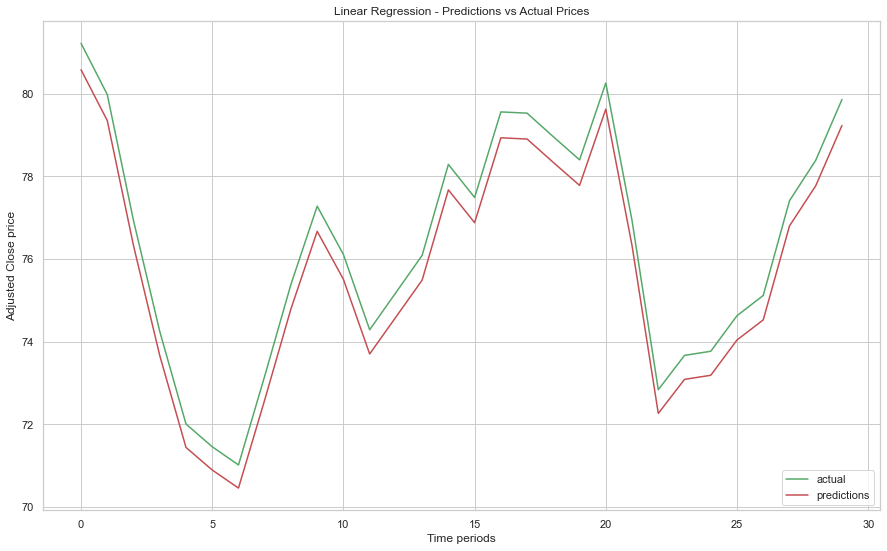

In [35]:
# Plot predictions against actual Adjusted Close prices  

x_axis = np.array(range(0, predictions.shape[0]))
plt.plot(x_axis, X_forecast, color='g', label="actual")
plt.plot(x_axis, predictions, color='r', label="predictions")
plt.xlabel('Time periods')
plt.ylabel('Adjusted Close price')
plt.title('Linear Regression - Predictions vs Actual Prices')
plt.legend(loc='lower right')
plt.show()

We can see that there is now a much better fit.

### 7.2 Create and train MLP Regressor model

The Multi-Layer Perceptron (MLP) Regressor model from scikit-learn is a class of feedforward neural network. We will create and train the model for 500 iterations using the 'lbfgs' solver which is more suited to smaller data sets and can converge faster and perform better than stochastic solvers like 'sgd' and 'adam' which work well on relatively large datasets (with thousands of training samples or more).

In [36]:
# Create an MLP Regressor model  
mlpr = MLPRegressor(max_iter=500, solver = 'lbfgs')

# Train the model using the training sets
mlpr.fit(X_train, y_train)
mlpr

MLPRegressor(max_iter=500, solver='lbfgs')

In [37]:
# Make predictions using the model
predictions = mlpr.predict(X_test)

### Print performance metrics

In [38]:
# The mean squared error
print('RMSE: {}'.format(round(mean_squared_error(y_test, predictions, squared=False), 3)))
# Explained variance score: 1 is perfect prediction, 0 is random
print('R^2 score: {}'.format(round(r2_score(y_test, predictions), 3)))

RMSE: 10.315
R^2 score: 0.788


The R<sup>2</sup> score tells us that 83% of the variation in y can be explained by the dependence on X.

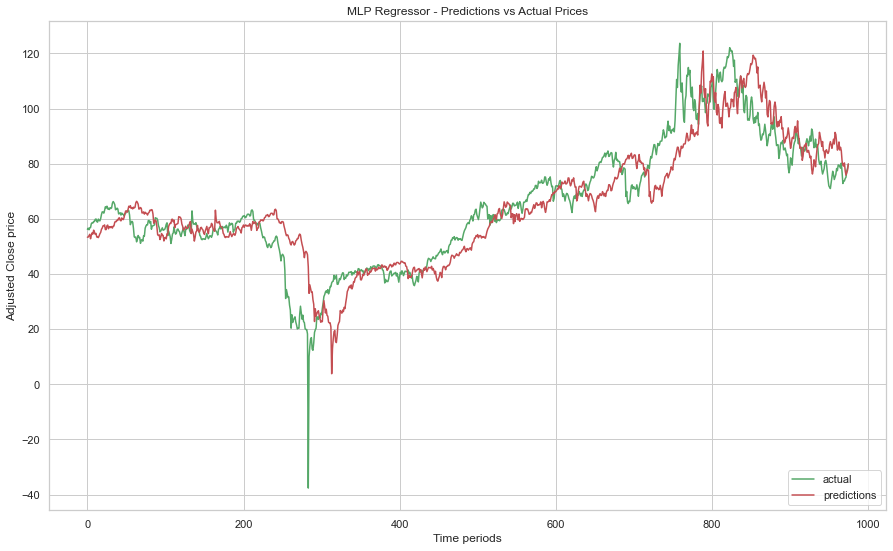

In [39]:
# Plot predictions against actual Adjusted Close prices 

x_axis = np.array(range(0, predictions.shape[0]))
plt.plot(x_axis, y_test, color='g', label="actual")
plt.plot(x_axis, predictions, color='r', label="predictions")
plt.xlabel('Time periods')
plt.ylabel('Adjusted Close price')
plt.title('MLP Regressor - Predictions vs Actual Prices')
plt.legend(loc='lower right')
plt.show()

### Create DataFrame of actual vs predicted prices

In [40]:
pd.DataFrame({"Actual": y_test, "Predict": predictions}).head()

,Actual,Predict
0,56.220001,53.358873
1,56.660000,53.406354
2,56.070000,53.890670
3,56.790001,54.422463
4,56.869999,52.808086


### Scatterplot

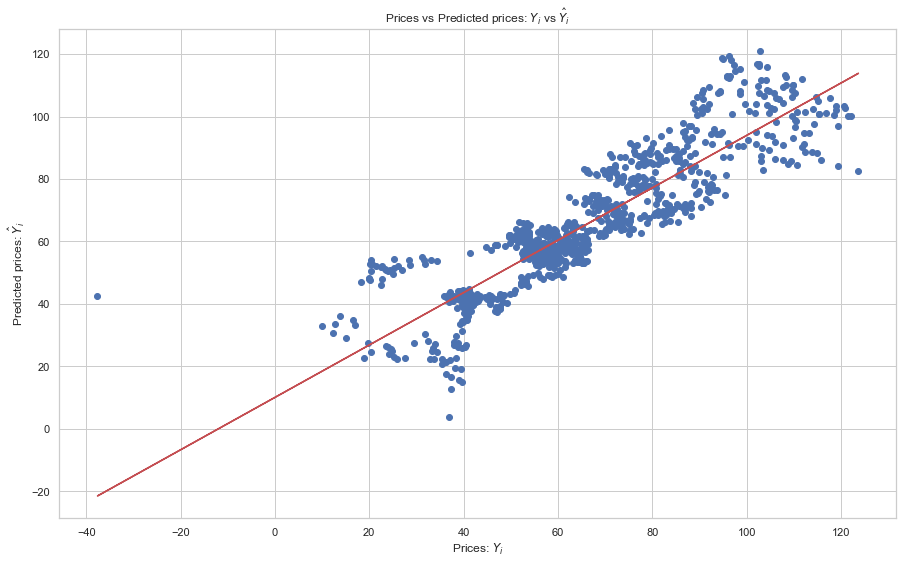

In [41]:
# create basic scatterplot
plt.scatter(y_test,predictions)

# obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(y_test, predictions, 1)

# add linear regression line to scatterplot 
plt.plot(y_test, m*y_test+b, c='r')

plt.xlabel("Prices: $Y_i$")
plt.ylabel("Predicted prices: $\hat{Y}_i$")
plt.title("Prices vs Predicted prices: $Y_i$ vs $\hat{Y}_i$")
plt.show()

### Predict next 30 days 

We will test the model on the X_forecast data and compare predictions with actual prices.

In [42]:
# Predicted prices

mlpr_prediction = mlpr.predict(X_forecast)
print(mlpr_prediction)

[80.56591949 79.388374   76.49198407 73.94696173 71.81978114 71.29747894
 70.87963719 72.92135409 75.02954515 76.8243549  75.71328358 73.984948
 74.83962103 75.69428682 77.78348837 77.0237774  78.98952175 78.96103386
 78.41974215 77.88794881 79.65427067 76.49198407 72.60797277 73.39617163
 73.49113369 74.30782045 74.77314687 76.9478121  77.87845043 79.27441518]


In [43]:
print(X_forecast)

[[81.22000122]
 [79.98000336]
 [76.93000031]
 [74.25      ]
 [72.01000214]
 [71.45999908]
 [71.01999664]
 [73.16999817]
 [75.38999939]
 [77.27999878]
 [76.11000061]
 [74.29000092]
 [75.19000244]
 [76.08999634]
 [78.29000092]
 [77.48999786]
 [79.55999756]
 [79.52999878]
 [78.95999908]
 [78.40000153]
 [80.26000214]
 [76.93000031]
 [72.83999634]
 [73.66999817]
 [73.76999664]
 [74.62999725]
 [75.12000275]
 [77.41000366]
 [78.38999939]
 [79.86000061]]


### Print performance metrics

In [44]:
# The mean squared error
print('RMSE: {}'.format(round(mean_squared_error(X_forecast, mlpr_prediction, squared=False), 3)))
# Explained variance score: 1 is perfect prediction, 0 is random
print('R^2 score: {}'.format(round(r2_score(X_forecast, mlpr_prediction), 3)))

RMSE: 0.43
R^2 score: 0.976


The R<sup>2</sup> score tells us that 84% of the variation in y can be explained by the dependence on X. 

### Visualise predicted vs actual prices

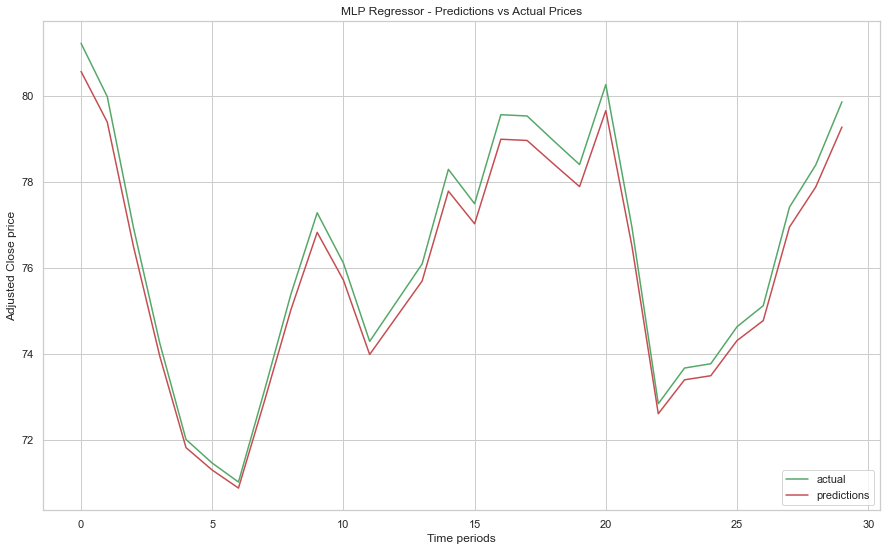

In [45]:
# Plot predictions against actual Adjusted Close prices 

x_axis = np.array(range(0, mlpr_prediction.shape[0]))
plt.plot(x_axis, X_forecast, color='g', label="actual")
plt.plot(x_axis, mlpr_prediction, color='r', label="predictions")
plt.xlabel('Time periods')
plt.ylabel('Adjusted Close price')
plt.title('MLP Regressor - Predictions vs Actual Prices')
plt.legend(loc='lower right')
plt.show()

#### Create DataFrame of actual vs predicted prices

In [46]:
# Reshape data to be 1D
X_forecast = X_forecast.reshape(-1)

In [47]:
pd.DataFrame({"Actual": X_forecast, "Predict": mlpr_prediction}).head()

,Actual,Predict
0,81.220001,80.565919
1,79.980003,79.388374
2,76.930000,76.491984
3,74.250000,73.946962
4,72.010002,71.819781


### Feature scaling
Multi-layer Perceptron is sensitive to feature scaling. We will normalise the training data before model fitting by converting values to a common scale. Scikit-Learn’s MinMaxScaler() function scales the data to values between 0 and 1 which helps boost performance. This is useful for optimisation algorithms and used in the core of machine learning algorithms like gradient descent. It is also useful for algorithms that weight inputs, like regression and neural networks.

In [48]:
# Reshape data as this needs to be 2D
y_train = y_train.reshape(-1, 1)

In [49]:
# Normalise data to improve convergence

scaler = MinMaxScaler(feature_range=(0, 1))
X_train_norm = scaler.fit_transform(X_train)
y_train_norm = scaler.transform(y_train)
X_test_norm = scaler.transform(X_test)

### Grid Search to find optimum parameters

In [50]:
# Create model

mlpr = MLPRegressor(max_iter=500)

In [51]:
# Create dictionary of parameters to iterate over

parameters = {"hidden_layer_sizes": [(50,50,50), (50,100,50), (100,)],
              "activation": ["identity", "logistic", "tanh", "relu"], 
              "solver": ["lbfgs", "sgd", "adam"], 
              "alpha": [0.0001, 0.05], 
              "learning_rate": ['constant','adaptive']}

In [52]:
# Grid search to find best parameters

gridsearchcv_mlpr = GridSearchCV(estimator=mlpr, param_grid=parameters, cv=tscv, scoring='r2')
grid_result_mlpr = gridsearchcv_mlpr.fit(X_train_norm, y_train_norm)
print("Best: {} using {}".format(grid_result_mlpr.best_score_, grid_result_mlpr.best_params_))

Best: -0.18521315278296718 using {'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'constant', 'solver': 'lbfgs'}


In [53]:
# All of the best parameters for the optimal model  

best_model_mlpr = grid_result_mlpr.best_estimator_
print(f"Best model has the following hyperparameters: {best_model_mlpr}")

Best model has the following hyperparameters: MLPRegressor(activation='tanh', alpha=0.05, hidden_layer_sizes=(50, 100, 50),
             max_iter=500, solver='lbfgs')


### Create, train and test tuned model

In [54]:
# Reshape data to be 2D
X_forecast = X_forecast.reshape(-1,1)
X_forecast

array([[81.22000122],
       [79.98000336],
       [76.93000031],
       [74.25      ],
       [72.01000214],
       [71.45999908],
       [71.01999664],
       [73.16999817],
       [75.38999939],
       [77.27999878],
       [76.11000061],
       [74.29000092],
       [75.19000244],
       [76.08999634],
       [78.29000092],
       [77.48999786],
       [79.55999756],
       [79.52999878],
       [78.95999908],
       [78.40000153],
       [80.26000214],
       [76.93000031],
       [72.83999634],
       [73.66999817],
       [73.76999664],
       [74.62999725],
       [75.12000275],
       [77.41000366],
       [78.38999939],
       [79.86000061]])

In [55]:
# Create MLP Regression model  
mlpr = MLPRegressor(activation='relu', alpha=0.05, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100,), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=500,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=None, shuffle=True, solver='lbfgs',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)

# Train the model using the training sets
mlpr.fit(X_train, y_train)

# Make predictions using the model
predictions = mlpr.predict(X_forecast)

# The mean squared error
print('RMSE: {}'.format(round(mean_squared_error(X_forecast, predictions, squared=False), 3)))
# Explained variance score: 1 is perfect prediction, 0 is random
print('R^2 score: {}'.format(round(r2_score(X_forecast, predictions), 3)))

RMSE: 0.43
R^2 score: 0.976


The R<sup>2</sup> score has increased from 84% to 97%.

### Visualise predicted vs actual prices of tuned model

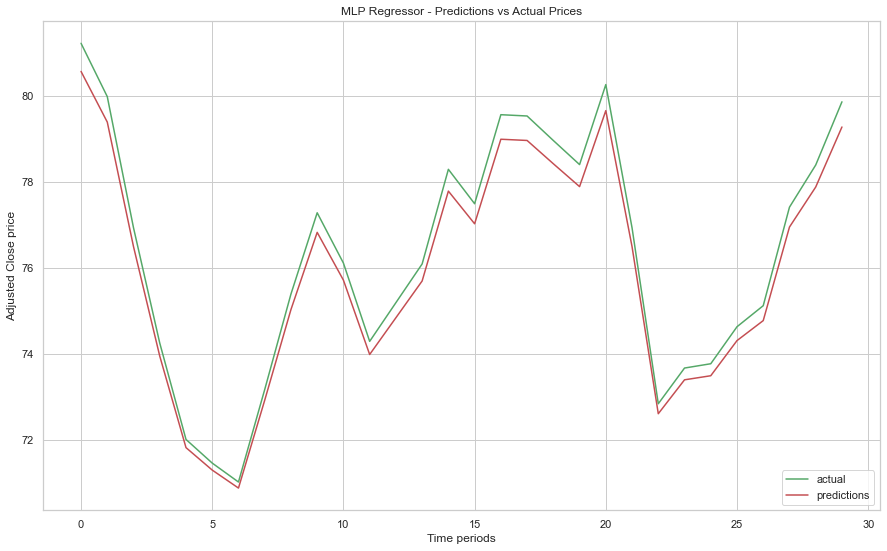

In [56]:
# Plot predictions against actual Adjusted Close prices

x_axis = np.array(range(0, predictions.shape[0]))
plt.plot(x_axis, X_forecast, color='g', label="actual")
plt.plot(x_axis, predictions, color='r', label="predictions")
plt.xlabel('Time periods')
plt.ylabel('Adjusted Close price')
plt.title('MLP Regressor - Predictions vs Actual Prices')
plt.legend(loc='lower right')
plt.show()